### Uncomment the following blocks in order to install dependencies in Google Colab

In [1]:
 ! git clone https://github.com/stellagerantoni/learning-time-series-counterfactuals
 %cd learning-time-series-counterfactuals/

fatal: destination path 'learning-time-series-counterfactuals' already exists and is not an empty directory.
/content/learning-time-series-counterfactuals


In [2]:


!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw

In [3]:
import sys
sys.path.append('./learning-time-series-counterfactuals/src')
sys.path.append('./learning-time-series-counterfactuals/LIMESegment/Utils/')

### Actual codes start

In [4]:
import logging
import os
import warnings
from argparse import ArgumentParser

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals

from _composite import ModifiedLatentCF
%cd src
from _vanilla import LatentCF
from help_functions import (ResultWriter, conditional_pad, evaluate,
                            find_best_lr, plot_graphs,
                            reset_seeds, time_series_normalize,
                            time_series_revert, upsample_minority,
                            validity_score)
from keras_models import *

/content/learning-time-series-counterfactuals/src


In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [6]:
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


In [8]:
logger = logging.getLogger(__name__)
logger.info(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}.")
RANDOM_STATE = 39

DATASET_NAME = "TwoLeadECG"
OUTPUT_FILENAME = "twolead-outfile.csv"
result_writer = ResultWriter(file_name=OUTPUT_FILENAME, dataset_name=DATASET_NAME)
logger.info(f"Result writer is ready, writing to {OUTPUT_FILENAME}...")
result_writer.write_head()


In [9]:
# 1. Load data
X, y = load_dataset(DATASET_NAME, repository="wildboar/ucr")

pos = 1
neg = 2
# Convert positive and negative labels to 1 and 0
pos_label, neg_label = 1, 0
y_copy = y.copy()
if pos != pos_label:
    y_copy[y==pos] = pos_label # convert/normalize positive label to 1
if neg != neg_label:
    y_copy[y==neg] = neg_label # convert negative label to 0

X_train, X_test, y_train, y_test = train_test_split(X, y_copy, test_size=0.2, random_state=RANDOM_STATE, stratify=y_copy)

# Upsample the minority class
y_train_copy = y_train.copy()
X_train, y_train = upsample_minority(X_train, y_train, pos_label=pos_label, neg_label=neg_label)
if y_train.shape != y_train_copy.shape:
    logger.info(f"Data upsampling performed, current distribution of y: \n{pd.value_counts(y_train)}.")


In [10]:
# ### 1.1 Normalization - fit scaler using training data
n_training, n_timesteps = X_train.shape
n_features = 1

X_train_processed, trained_scaler = time_series_normalize(data=X_train, n_timesteps=n_timesteps)
X_test_processed, _ = time_series_normalize(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler)

X_train_processed_padded, padding_size = conditional_pad(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad(X_test_processed)
n_timesteps_padded = X_train_processed_padded.shape[1]
logger.info(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")


In [11]:
y_train_classes = y_train
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

In [12]:
X_train_processed_padded.shape


(930, 84, 1)

In [13]:
n_lstmcells = 8

# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()

###############################################
# ## 2.0 LSTM-FCN classifier
###############################################
# ### LSTM-FCN classifier
classifier = LSTMFCNClassifier(
    n_timesteps_padded, n_features, n_output=2, n_LSTM_cells=n_lstmcells
)

optimizer = keras.optimizers.Adam(lr=0.0001)
classifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=30, restore_best_weights=True
)
# Train the model
reset_seeds()
logger.info("Training log for LSTM-FCN classifier:")
classifier_history = classifier.fit(
    X_train_processed_padded,
    y_train,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(X_test_processed_padded, y_test),
    callbacks=[early_stopping_accuracy],
)

y_pred = classifier.predict(X_test_processed_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:pos", "True:neg"],
    columns=["Pred:pos", "Pred:neg"],
)
print(f"Confusion matrix: \n{confusion_matrix_df}.")

Epoch 1/150
30/30 [==============================] - 25s 107ms/step - loss: 0.2353 - accuracy: 0.9172 - val_loss: 0.6836 - val_accuracy: 0.4979
Epoch 2/150
30/30 [==============================] - 1s 33ms/step - loss: 0.0853 - accuracy: 0.9817 - val_loss: 0.6809 - val_accuracy: 0.5021
Epoch 3/150
30/30 [==============================] - 1s 35ms/step - loss: 0.0575 - accuracy: 0.9882 - val_loss: 0.6718 - val_accuracy: 0.5021
Epoch 4/150
30/30 [==============================] - 1s 34ms/step - loss: 0.0336 - accuracy: 0.9968 - val_loss: 0.6723 - val_accuracy: 0.5021
Epoch 5/150
30/30 [==============================] - 1s 39ms/step - loss: 0.0437 - accuracy: 0.9914 - val_loss: 0.6776 - val_accuracy: 0.5021
Epoch 6/150
30/30 [==============================] - 1s 41ms/step - loss: 0.0307 - accuracy: 0.9968 - val_loss: 0.5990 - val_accuracy: 0.5536
Epoch 7/150
30/30 [==============================] - 1s 49ms/step - loss: 0.0186 - accuracy: 0.9978 - val_loss: 0.5220 - val_accuracy: 0.7897
Epoc

## 1dCNN search

In [14]:
###############################################
# ## 2.1 CF search with 1dCNN autoencoder
###############################################
# ### 1dCNN autoencoder
autoencoder = Autoencoder(n_timesteps_padded, n_features)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=5, restore_best_weights=True
)
# Train the model
reset_seeds()
logger.info("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train_processed_padded,
    X_train_processed_padded,
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=True,
    validation_data=(X_test_processed_padded, X_test_processed_padded),
    callbacks=[early_stopping],
)

ae_val_loss = np.min(autoencoder_history.history["val_loss"])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


Epoch 1/50
30/30 [==============================] - 3s 16ms/step - loss: 0.1719 - val_loss: 0.0260
Epoch 2/50
30/30 [==============================] - 0s 8ms/step - loss: 0.0146 - val_loss: 0.0102
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.0078 - val_loss: 0.0049
Epoch 4/50
30/30 [==============================] - 0s 8ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 5/50
30/30 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 9.3922e-04 - val_loss: 6.6909e-04
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 5.6161e-04 - val_loss: 4.5488e-04
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 4.1716e-04 - val_loss: 3.6237e-04
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 3.3061e-04 - val_loss: 2.9506e-04
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 2.6641e-0

## CF search, original

In [15]:
import warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras

from wildboar.explain import IntervalImportance
from LIMESegment.Utils.explanations import LIMESegment

def get_global_weights_fixed(
    input_samples, input_labels, classifier_model, n_timesteps, n_features, random_state=None,
):
    n_samples, n_timesteps, n_dims = input_samples.shape  # n_dims=1

    class ModelWrapper:
        def __init__(self, model, n_timesteps, n_features):
            self.model = model
            self.fitted_ = False
            self.n_timesteps_in_ = n_timesteps
            self.n_features_in_ = n_features

        def predict(self, X):
            p = self.model.predict(X.reshape(n_samples, n_timesteps, 1))
            return np.argmax(p, axis=1)

        def fit(self, X, y):

          self.fitted_ = True
          return self.model.fit(X, y)

    clf = ModelWrapper(classifier_model, n_timesteps, n_features)

    i = IntervalImportance(scoring="accuracy",n_intervals=10, random_state=random_state)
    i.fit(clf, input_samples.reshape(input_samples.shape[0], -1), input_labels)

    # calculate the threshold of masking, 75 percentile
    masking_threshold = np.percentile(i.importances_.mean, 75)
    masking_idx = np.where(i.importances_.mean >= masking_threshold)

    weighted_steps = np.ones(n_timesteps)
    seg_idx = i.components_
    for start_idx in masking_idx[0]:
        weighted_steps[seg_idx[start_idx][0] : seg_idx[start_idx][1]] = 0

    # need to reshape for multiplication in `tf.math.multiply()`
    weighted_steps = weighted_steps.reshape(1, n_timesteps, 1)
    return weighted_steps

In [16]:
from _guided import get_global_weights
from help_functions import evaluate2
PRED_MARGIN_W_LIST = [1]
w_type = "global"

if w_type == "global":
    step_weights = get_global_weights_fixed(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        n_timesteps,
        n_features,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

30/30 [==============================] - 0s 3ms/step


In [17]:
X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
y_pred_neg = y_pred_classes[y_pred_classes==neg_label][:10]

In [18]:

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)

    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, best_cf_embeddings = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

======================== CF search started, with lr=0.0001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 39ms/step
lr=0.0001 finished. Validity: 0.8, proximity: 0.1554794373542064.
The best learning rate found is 0.0001.


In [19]:
     # predicted probabilities of CFs
z_pred = classifier.predict(best_cf_samples)[:, 1]
if padding_size != 0:
  # remove extra paddings after counterfactual generation in 1dCNN autoencoder
  best_cf_samples = best_cf_samples[:, :-padding_size, :]
  # use the unpadded X for evaluation
  X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
else:
  X_pred_neg_orignal = X_pred_neg

evaluate_res = evaluate2(
    X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
)



1/1 [==============================] - 0s 27ms/step


In [20]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")
print(f"acc={acc}, ae_val_loss = {ae_val_loss}, best_lr = {best_lr}, evaluate_res = {evaluate_res}, pred_margin_weight = {pred_margin_weight}")

Done for CF search [1dCNN autoencoder], pred_margin_weight=1.
acc=0.9914529914529915, ae_val_loss = 0.00011910798639291897, best_lr = 0.0001, evaluate_res = (0.15518292352715263, 0.8, 4.5514105e-05, 0.0026787266), pred_margin_weight = 1


In [21]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [22]:
sample_id = 3

In [23]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

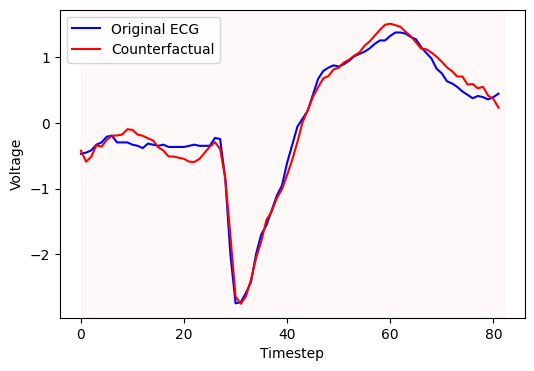

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
color = 'lightcoral' # if weight < 0 else 'green'
plt.axvspan(0, 82, color=color, alpha=0.05)
plt.show()

In [25]:
print(z_pred)

[0.49370417 0.5007837  0.50019145 0.5050602  0.4980416  0.5009568
 0.50058216 0.50003177 0.50024897 0.5008544 ]


## NoAE search

In [26]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes == neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3,best_cf_embeddings3 = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res3 = evaluate2(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

======================== CF search started, with lr=0.001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 27ms/step
lr=0.001 finished. Validity: 0.9, proximity: 0.10977537465003029.
The best learning rate found is 0.001.
1/1 [==============================] - 0s 29ms/step
Done for CF search [No autoencoder], pred_margin_weight=1.


In [27]:
z_pred

array([0.49370417, 0.5007837 , 0.50019145, 0.5050602 , 0.4980416 ,
       0.5009568 , 0.50058216, 0.50003177, 0.50024897, 0.5008544 ],
      dtype=float32)

In [28]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

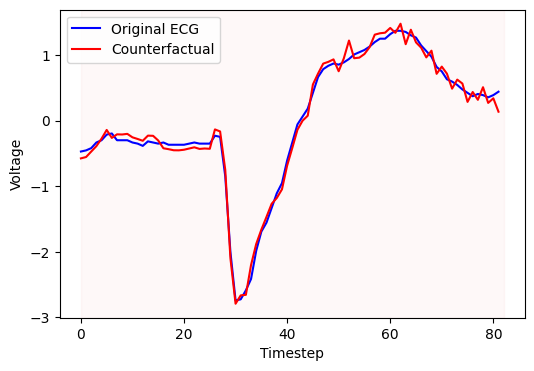

In [29]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
color = 'lightcoral' # if weight < 0 else 'green'
plt.axvspan(0, 82, color=color, alpha=0.05)
plt.show()

In [30]:
print(z_pred3)

[0.5105523  0.50092113 0.49773034 0.5006357  0.500538   0.5008253
 0.50064075 0.5004723  0.50030077 0.5002213 ]


## global, pred_margin_weight = 0.5

In [31]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [0.5]
w_type = "global"

if w_type == "global":
    step_weights = get_global_weights_fixed(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes == neg_label][:10]
    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res = evaluate2(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



30/30 [==============================] - 0s 5ms/step
======================== CF search started, with lr=0.0001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 42ms/step
lr=0.0001 finished. Validity: 0.9, proximity: 0.1578549206995711.
The best learning rate found is 0.0001.
1/1 [==============================] - 0s 42ms/step


In [32]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


Done for CF search [1dCNN autoencoder], pred_margin_weight=0.5.


In [33]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [34]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

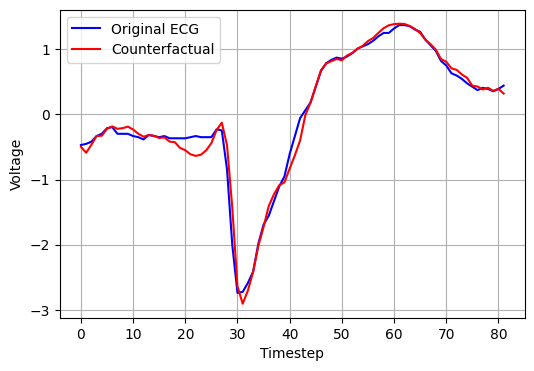

In [35]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [36]:
print(z_pred)

[0.3169494  0.50021183 0.5004725  0.56431085 0.5008521  0.5007257
 0.50029397 0.5003496  0.5000658  0.5004104 ]


In [37]:
from wildboar.explain import *

class ModelWrapper:
    def __init__(self, model, n_timesteps, n_features):
        self.model = model
        self.fitted_ = False
        self.n_timesteps_in_ = n_timesteps_padded
        self.n_features_in_ = n_features

    def predict(self, X):
        p = self.model.predict(X.reshape(X.shape[0], -1, 1))
        return np.argmax(p, axis=1) # I think this would work?

    def fit(self, X, y):
        self.fitted_ = True
        return self.model.fit(X, y)

clf = ModelWrapper(classifier, n_timesteps_padded, n_features)

i = IntervalImportance(scoring="accuracy", n_intervals=10, random_state=RANDOM_STATE)
i.fit(clf, X_train_processed_padded.reshape(X_train_processed_padded.shape[0], -1), y_train_classes)

30/30 [==============================] - 0s 4ms/step


IntervalImportance(n_intervals=10, random_state=39, scoring='accuracy')

In [38]:
print(i.importances_.mean)

[0.08301075 0.16215054 0.16645161 0.21827957 0.16451613 0.15892473
 0.01397849 0.01096774 0.00645161 0.00580645]


In [39]:
seg_idx = i.components_
seg_imp = i.importances_.mean

In [40]:
# calculate the threshold of masking, 75 percentile
masking_threshold = np.percentile(seg_imp, 75)
# masking_threshold = np.percentile(i.importances_.mean, 25)
print(masking_threshold)
masking_idx = np.where(seg_imp >= masking_threshold)
print(masking_idx)
weighted_steps = np.ones(X_test_processed_padded.shape[1])
print(weighted_steps.shape)

for start_idx in masking_idx[0]:
    weighted_steps[seg_idx[start_idx][0] : seg_idx[start_idx][1]] = 0


0.16392473118279577
(array([2, 3, 4]),)
(84,)


In [41]:
masking_threshold

0.16392473118279577

0, 9: 0.08301075268817208
9, 18: 0.16215053763440868
18, 27: 0.16645161290322588
27, 36: 0.21827956989247319
36, 44: 0.16451612903225815
44, 52: 0.15892473118279576
52, 60: 0.01397849462365599
60, 68: 0.010967741935483933
68, 76: 0.006451612903225867


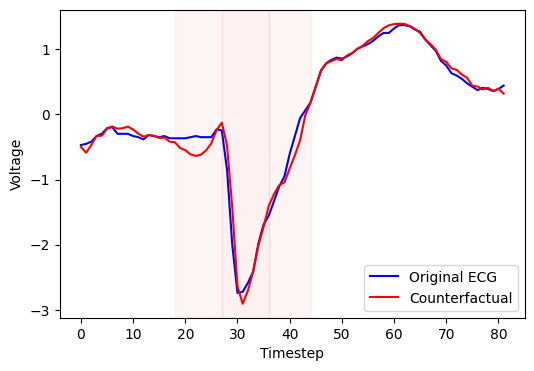

In [42]:
import math

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
# plt.legend(loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i][0]
    end = seg_idx[i+1][0]
    print(f'{start}, {end}: {weight}')
    if weight <= masking_threshold:
        continue
    color = 'lightcoral' # if weight < 0 else 'green'
    plt.axvspan(start, end, color=color, alpha=abs(weight)*0.5)
plt.xlabel("Timestep")
plt.ylabel("Voltage")
# plt.grid()
plt.show()


## NoAE search

In [43]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes == neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg

    evaluate_res3 = evaluate2(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

======================== CF search started, with lr=0.001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 31ms/step
lr=0.001 finished. Validity: 1.0, proximity: 0.11444377071471452.
The best learning rate found is 0.001.
1/1 [==============================] - 0s 29ms/step
Done for CF search [No autoencoder], pred_margin_weight=0.5.


In [44]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

0, 9: 0.08301075268817208
9, 18: 0.16215053763440868
18, 27: 0.16645161290322588
27, 36: 0.21827956989247319
36, 44: 0.16451612903225815
44, 52: 0.15892473118279576
52, 60: 0.01397849462365599
60, 68: 0.010967741935483933
68, 76: 0.006451612903225867


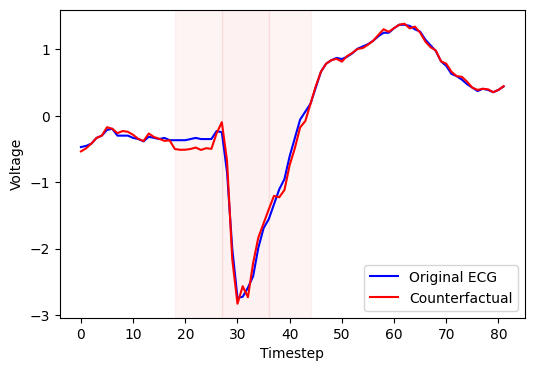

In [45]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
# plt.legend(loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i][0]
    end = seg_idx[i+1][0]
    print(f'{start}, {end}: {weight}')
    if weight <= masking_threshold:
        continue
    color = 'lightcoral' # if weight < 0 else 'green'
    plt.axvspan(start, end, color=color, alpha=abs(weight)*0.5)
plt.xlabel("Timestep")
plt.ylabel("Voltage")
# plt.grid()
plt.show()


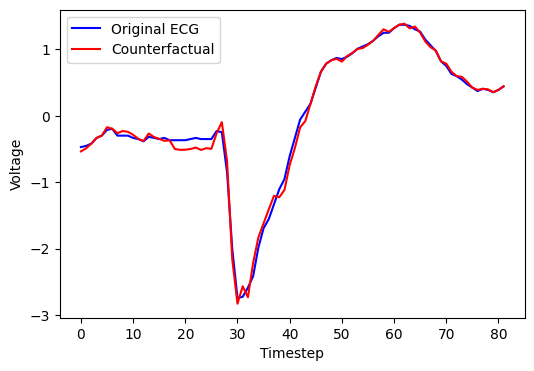

In [46]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
plt.show()

In [47]:
step_weights.reshape(-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [48]:
print(z_pred3)

[0.5100356  0.500729   0.50034016 0.5006376  0.50019574 0.50038123
 0.5007629  0.50032127 0.5004372  0.500575  ]


## local, pred_margin_weight = 0.5

In [49]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [0.5]
w_type = "local"

if w_type == "global":
    step_weights = get_global_weights(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes == neg_label][:10]

    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res = evaluate2(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



======================== CF search started, with lr=0.0001.
1 samples been transformed.
4/4 [==============================] - 0s 10ms/step
10 samples been transformed, in total.
1/1 [==============================] - 0s 29ms/step
lr=0.0001 finished. Validity: 0.5, proximity: 0.11821911736282815.
The best learning rate found is 0.0001.
1/1 [==============================] - 0s 27ms/step


In [50]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


Done for CF search [1dCNN autoencoder], pred_margin_weight=0.5.


In [51]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [52]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

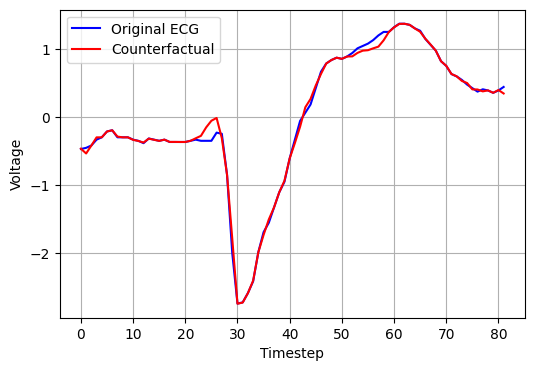

In [53]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
plt.grid()
plt.show()

In [54]:
print(z_pred)

[4.6640927e-09 5.0070626e-01 9.8428598e-07 1.4451510e-07 5.1285100e-01
 5.0075722e-01 5.0051993e-01 1.1060198e-06 1.3882013e-07 5.0064433e-01]


In [55]:
from LIMESegment.Utils.explanations import LIMESegment

series = X_pred_neg[sample_id]

seg_imp, seg_idx = LIMESegment(
        series,
        classifier,
        model_type=1,
        cp=10,
        window_size=10,
        random_state=RANDOM_STATE,
    )

4/4 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [56]:
# seg_imp, seg_idx = explanations
total_len = len(series)
seg_idx[-1] = total_len - padding_size
# seg_idx[-1] = total_len

In [57]:
# calculate the threshold of masking, 25 percentile
masking_threshold = np.percentile(seg_imp, 25)
masking_idx = np.where(seg_imp <= masking_threshold)

masking_threshold

-0.10917438147963834

0, 10: -0.06653668491419444
10, 22: 0.20698504883176913
22, 28: -0.13845597936883988
28, 33: 0.13052355657769615
33, 41: -0.01677566913786679
41, 47: -0.23380307911769121
47, 52: -0.06508213405350337
52, 59: -0.1898440132552883
59, 66: 0.08044304298806561
66, 71: -0.029441859296517284
71, 82: -0.07989278359043682


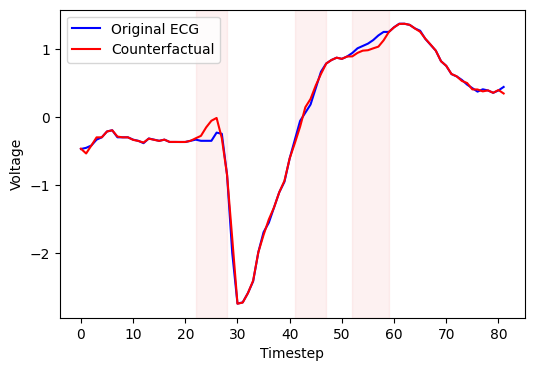

In [58]:
import math

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
# plt.legend(loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend(loc='upper left')

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i]
    end = seg_idx[i+1]
    print(f'{start}, {end}: {weight}')
    if weight >= masking_threshold:
        continue
    color = 'lightcoral' #if weight < 0 else 'green'
    plt.axvspan(start, end, color=color, alpha=0.11)#abs(weight))
plt.xlabel("Timestep")
plt.ylabel("Voltage")
# plt.grid()
plt.show()

In [59]:
from LIMESegment.Utils.explanations import LIMESegment

def get_local_weights(input_sample, classifier_model, random_state=None):
    n_timesteps, n_dims = input_sample.shape  # n_dims=1
    seg_imp, seg_idx = LIMESegment(
        input_sample,
        classifier_model,
        model_type=1,
        cp=10,
        window_size=10,
        random_state=random_state,
    )

    # calculate the threshold of masking, 25 percentile
    masking_threshold = np.percentile(seg_imp, 25)
    masking_idx = np.where(seg_imp <= masking_threshold)

    weighted_steps = np.ones(n_timesteps)
    for start_idx in masking_idx[0]:
        weighted_steps[seg_idx[start_idx] : seg_idx[start_idx + 1]] = 0

    # need to reshape for multiplication in `tf.math.multiply()`
    weighted_steps = weighted_steps.reshape(1, n_timesteps, n_dims)
    return weighted_steps

In [60]:
series = X_pred_neg[sample_id]

step_weights = get_local_weights(
    series, classifier, random_state=RANDOM_STATE
)

4/4 [==============================] - 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [61]:
step_weights.reshape(-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## NoAE search

In [62]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes == neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res3 = evaluate2(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

======================== CF search started, with lr=0.001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 31ms/step
lr=0.001 finished. Validity: 0.9, proximity: 0.11285234174766386.
The best learning rate found is 0.001.
1/1 [==============================] - 0s 31ms/step
Done for CF search [No autoencoder], pred_margin_weight=0.5.


In [63]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

0, 10: -0.06653668491419444
10, 22: 0.20698504883176913
22, 28: -0.13845597936883988
28, 33: 0.13052355657769615
33, 41: -0.01677566913786679
41, 47: -0.23380307911769121
47, 52: -0.06508213405350337
52, 59: -0.1898440132552883
59, 66: 0.08044304298806561
66, 71: -0.029441859296517284
71, 82: -0.07989278359043682


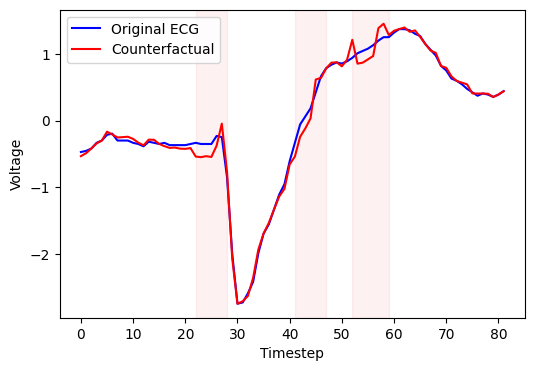

In [64]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
# plt.plot(np.mean(X_test[y_test_classes == 1], axis=0), color='green', label='Mean of other class')
# plt.legend(loc='lower left')
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend(loc='upper left')

for i in range(len(seg_idx)-1):
    weight = seg_imp[i]
    start = seg_idx[i]
    end = seg_idx[i+1]
    print(f'{start}, {end}: {weight}')
    if weight >= masking_threshold:
        continue
    color = 'lightcoral' #if weight < 0 else 'green'
    plt.axvspan(start, end, color=color, alpha=0.11)#abs(weight))
plt.xlabel("Timestep")
plt.ylabel("Voltage")
# plt.grid()
plt.show()

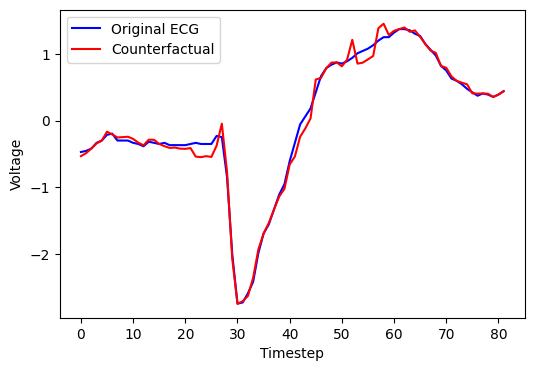

In [65]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
plt.show()

In [66]:
print(z_pred3)

[0.42538914 0.5003025  0.5002389  0.5009962  0.5001907  0.5003752
 0.5006731  0.500368   0.50023764 0.5006927 ]


## uniform, pred_margin_weight = 0.5

In [67]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [0.5]
w_type = "uniform"

if w_type == "global":
    step_weights = get_global_weights_fixed(
        X_train_processed_padded,
        y_train_classes,
        classifier,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )

### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes == neg_label][:10]
    lr_list = [0.0001]
    best_lr, best_cf_model, best_cf_samples, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=autoencoder,
        lr_list=lr_list,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr}.")

    # predicted probabilities of CFs
    z_pred = classifier.predict(best_cf_samples)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation in 1dCNN autoencoder
        best_cf_samples = best_cf_samples[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res = evaluate2(
        X_pred_neg_orignal, best_cf_samples, z_pred, n_timesteps
    )



======================== CF search started, with lr=0.0001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 29ms/step
lr=0.0001 finished. Validity: 0.4, proximity: 0.08389057584029602.
The best learning rate found is 0.0001.
1/1 [==============================] - 0s 29ms/step


In [68]:
result_writer.write_result(
    "1dCNN autoencoder",
    acc,
    ae_val_loss,
    best_lr,
    evaluate_res,
    pred_margin_weight=pred_margin_weight,
    step_weight_type=w_type.lower(),
)
print(f"Done for CF search [1dCNN autoencoder], pred_margin_weight={pred_margin_weight}.")


Done for CF search [1dCNN autoencoder], pred_margin_weight=0.5.


In [69]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs = time_series_revert(best_cf_samples, n_timesteps=n_timesteps, scaler=trained_scaler)

### plot for TwoLeadECG

In [70]:
original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs[sample_id, :]

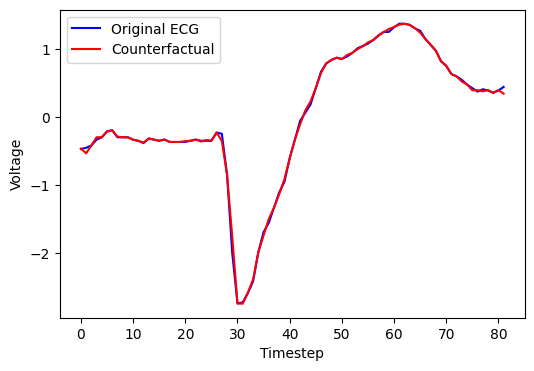

In [71]:
plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
plt.show()

In [72]:
print(z_pred[sample_id])

1.1434607e-06


## NoAE search

In [73]:
###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    logger.info(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes == neg_label][:10]

    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )



###############################################
# ## 2.3 CF search with no autoencoder
###############################################
for pred_margin_weight in PRED_MARGIN_W_LIST:
    print(f"The current prediction margin weight is {pred_margin_weight}.")

    # Get these instances of negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test_processed_padded[y_pred_classes == neg_label][:10]
    y_pred_neg = y_pred_classes[y_pred_classes == neg_label][:10]


    lr_list3 = [0.001]
    best_lr3, best_cf_model3, best_cf_samples3, _ = find_best_lr(
        classifier,
        X_pred_neg,
        y_pred_neg,
        autoencoder=None,
        lr_list=lr_list3,
        pred_margin_weight=pred_margin_weight,
        step_weights=step_weights,
        random_state=RANDOM_STATE,
    )
    print(f"The best learning rate found is {best_lr3}.")

    # ### Evaluation metrics
    # predicted probabilities of CFs
    z_pred3 = classifier.predict(best_cf_samples3)[:, 1]
    if padding_size != 0:
        # remove extra paddings after counterfactual generation
        best_cf_samples3 = best_cf_samples3[:, :-padding_size, :]
        # use the unpadded X for evaluation
        X_pred_neg_orignal = X_test_processed[y_pred_classes == neg_label][:10]
    else:
        X_pred_neg_orignal = X_pred_neg[:10]

    evaluate_res3 = evaluate2(
        X_pred_neg_orignal, best_cf_samples3, z_pred3, n_timesteps
    )

    result_writer.write_result(
        "No autoencoder",
        acc,
        0,
        best_lr3,
        evaluate_res3,
        pred_margin_weight=pred_margin_weight,
        step_weight_type=w_type.lower(),
    )
    print(f"Done for CF search [No autoencoder], pred_margin_weight={pred_margin_weight}.")

======================== CF search started, with lr=0.001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 31ms/step
lr=0.001 finished. Validity: 0.3, proximity: 0.017751719225462502.
The current prediction margin weight is 0.5.
======================== CF search started, with lr=0.001.
1 samples been transformed.
10 samples been transformed, in total.
1/1 [==============================] - 0s 45ms/step
lr=0.001 finished. Validity: 0.3, proximity: 0.017751719225462502.
The best learning rate found is 0.001.
1/1 [==============================] - 0s 45ms/step
Done for CF search [No autoencoder], pred_margin_weight=0.5.


In [74]:
# Uncomment to visualize the first 5 counterfactual samples
# Map the results back to the original scale, for comparison
actual_Xs = time_series_revert(X_pred_neg_orignal, n_timesteps=n_timesteps, scaler=trained_scaler)
actual_cfs3 = time_series_revert(best_cf_samples3, n_timesteps=n_timesteps, scaler=trained_scaler)

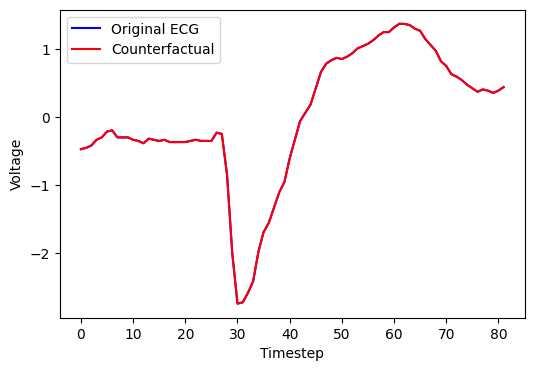

In [75]:

original_sample = actual_Xs[sample_id, :]
cf_sample = actual_cfs3[sample_id, :]

plt.figure(figsize=(6, 4))
plt.plot(original_sample, color='b', label="Original ECG")
plt.plot(cf_sample, color='r', label="Counterfactual")
plt.xlabel("Timestep")
plt.ylabel("Voltage")
plt.legend()
# plt.grid()
plt.show()

In [76]:
step_weights.reshape(-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [77]:
z_pred3


array([2.3326905e-09, 5.0017685e-01, 2.4728903e-08, 2.7423935e-06,
       1.3735589e-06, 5.0066221e-01, 7.4411918e-07, 9.9480258e-07,
       5.2053185e-08, 5.0011557e-01], dtype=float32)

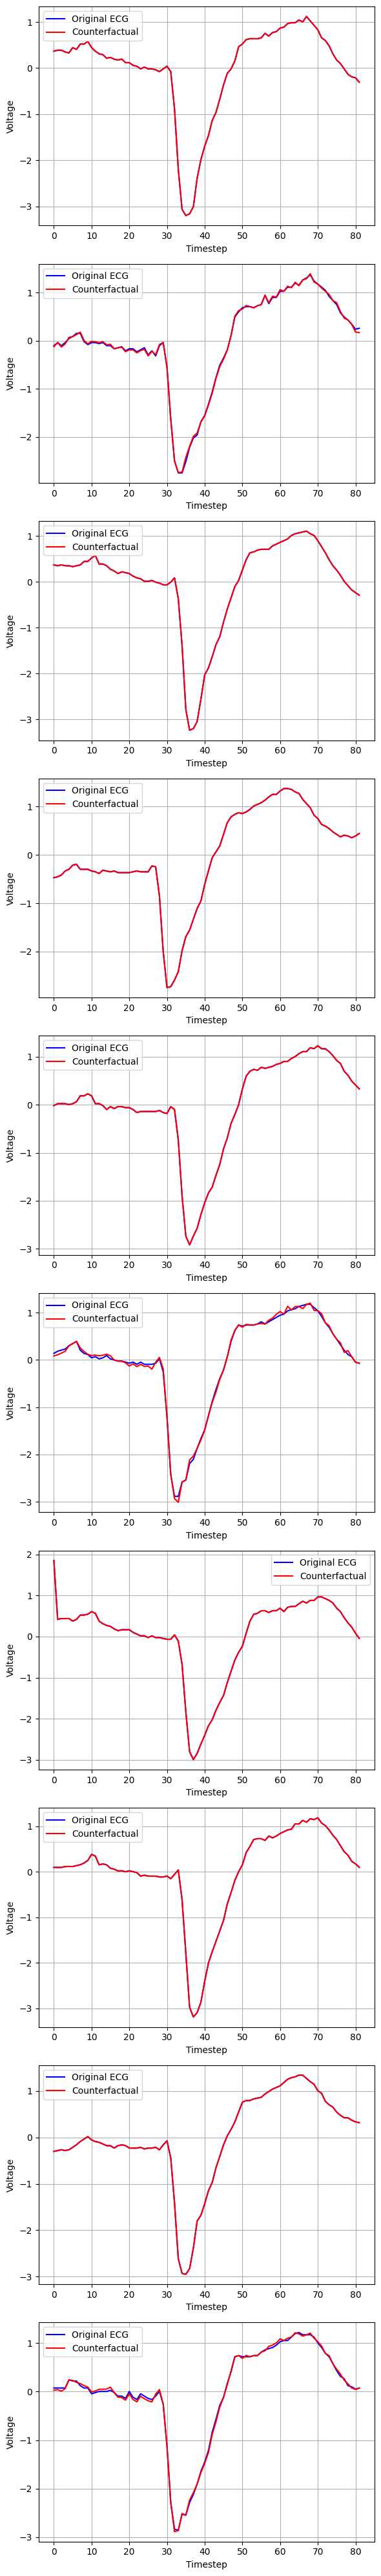

In [78]:
fig, axes = plt.subplots(10, 1, figsize=(6, 40))  # 10 rows, 1 column of plots

for idx in range(10):
    original_sample = actual_Xs[idx, :]
    cf_sample = actual_cfs3[idx, :]

    axes[idx].plot(original_sample, color='b', label="Original ECG")
    axes[idx].plot(cf_sample, color='r', label="Counterfactual")
    axes[idx].set_xlabel("Timestep")
    axes[idx].set_ylabel("Voltage")
    axes[idx].legend()
    axes[idx].grid()  # Uncomment if you want grid lines

plt.tight_layout()
plt.show()